In [9]:
import torch
import pandas as pd
import numpy as np
import h5py

from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

import pickle
from random import Random

import DENN_utils
from DENN_utils import *




import importlib
importlib.reload(DENN_utils)

tensor([ 0.9574,  0.5791, 47.6200], dtype=torch.float64)


<module 'DENN_utils' from '/Users/andersen/Desktop/DENN_Application/DENN Coding files/DENN_utils.py'>

### 1. Load Rosenzweig-Macarthur Simulation data

In [2]:
filepath = '../R-M data/final_output.mat'
full_data = get_RM_full_data(filepath)

### 2. Specify prior

In [3]:
num_dim = 2
uniform_prior = utils.BoxUniform(low = 0.19 * torch.ones(num_dim), high = 0.61 * torch.ones(num_dim))

Two notes: 
1. As the data reflects a discretized $(m,h)$ space with grid size of 0.02, the box-uniform support is to take care of edge value
2. As we only use the lower left triangle regime, we will symmetrically map the grids on the box uniform. For posterior data analysis, it will be re-mapped back

### 3. Specify simulator

In [6]:
test_parameter_sample = torch.tensor([0.2, 0.2])
test_sim_data = ODE_simulator_on_fine_grids(test_parameter_sample)
print(test_sim_data)

tensor([ 0.9617,  0.6409, 47.9500], dtype=torch.float64)


This is a test usage of R-M data simulator. `ODE_simulator_on_fine_grids` is implemented in `DENN_utils`. It is designed to be used out-of-box.

### 4. Train a network using SNLE

In [ ]:
num_of_sim = 10000
network_self = infer(ODE_simulator_on_fine_grids, uniform_prior, method = "SNLE", num_simulations = num_of_sim)

### 4.1 Test memory use

In [38]:
import psutil

def check_memory():
    process = psutil.Process()
    return process.memory_info().rss / (1024 * 1024)

memory_before = check_memory()
### Start your code
num_of_sim = 50
network_self = infer(ODE_simulator_embedded, uniform_prior, method = "SNLE", num_simulations = num_of_sim)


### End your code
memory_after = check_memory()

print(f"Memory used: {memory_after - memory_before} MB")


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

 Neural network successfully converged after 134 epochs.Memory used: 0.953125 MB


### 5. Save the network using pickle

In [17]:
save_to_pickle(network_self, 'network_self_pickle')

If you don't want to train the network every time, you can save it using pickle. Note that this is more suitable for short-term storage. For long term storage, consider using JSON

### 6. Load the network

In [9]:
network_self = load_from_pickle('network_self_pickle')

### 7. Test network performance

We use $[X_{amp}, Y_{amp}, T]$ data from $(m,h) = (0.6, 0.2)$ to evaluate the performance

In [6]:
test_data_0206 = full_data[20,0,:,:]
num_of_observations = 20
temp_observation = get_sample(test_data_0206, 20)

Then we use the network to perform density estimation. This process should yield a posterior sample given observation data

In [7]:
posterior_samples_from_network_1 = network_self.sample((200,), x = temp_observation)

/Users/andersen/miniconda3/lib/python3.11/site-packages/sbi/utils/sbiutils.py:316: UserWarning: An x with a batch size of 20 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

Extract $(m,h)$ part 

In [13]:
pos_sample_numpy = posterior_samples_from_network_1.numpy()
pos_sample_numpy = pos_sample_numpy[:,0:2]

Generate pairplot

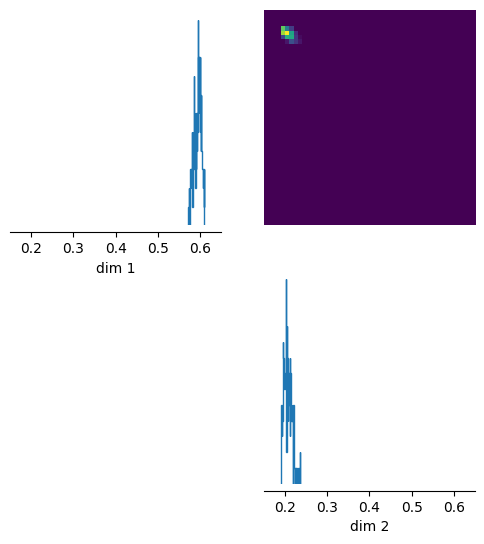

In [15]:
figure_0206 = analysis.pairplot(pos_sample_numpy, limits=[[0.15, 0.65], [0.15, 0.65]], figsize=(6, 6))
# Usually, the figure object is the first element in the tuple
fig = figure_0206[0]

# Now use the `savefig` method of the figure object to save it as an SVG
fig.savefig('plot.svg', format='svg')
